In [49]:
import torch as tn
import torch.nn as nn
import torch.nn.functional as F
import torchtt as tntt
import numpy as np
import tt_iga
import matplotlib.pyplot as plt
import torch as tn
import datetime
import torch.utils.data 

tn.set_default_dtype(tn.float64)

In [50]:

def create_geometry( ):
        
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3                                                            
    hi = 13e-3                                                             
    bli = 3e-3                                                             
    Dc = 3.27640e-2                                                           
    # Dc = 32e-3
    # hc = 7e-3
    hc = 7.55176e-3                                                           
    ri = 20e-3                                                           
    ra = 18e-3                                                           
    blc = hi-hc                                                           
    rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    R = rm-ri

    get_rO = lambda Ax,Ay,ri: (Ax**2+Ay**2-ri**2)/(np.sqrt(2)*(Ax+Ay)-2*ri)

    O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    alpha1 = -np.pi*3/4       
    alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    alpha = np.abs(alpha2-alpha1)
    
    A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    C = np.linalg.solve(A,b)

    def Cx(ri,Dc,hc):
        O = [((Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri) )/np.sqrt(2),((Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri) )/np.sqrt(2)]
        A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
        b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
        C = np.linalg.solve(A,b)
        return C[0]

    def Cy(ri,Dc,hc):
        O = [((Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri) )/np.sqrt(2),( (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)  )/np.sqrt(2)]
        A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
        b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
        C = np.linalg.solve(A,b)
        return C[1]

    control_points = tt_iga.geometry.ParameterDependentControlPoints([7,5])

    # params ri - 0 , Dc - 1 , Di - 2 
    control_points[:,0,0] = [0,0]
    control_points[:,1,0] = [lambda params: (Dc+params[1])/2, 0]
    control_points[:,2,0] = [lambda params: (Dc+params[1]), 0]
    control_points[:,3,0] = [(Dc+Di)/2,0]
    control_points[:,4,0] = [lambda params: Di+params[2],0]
    control_points[:,5,0] = [(Do+Di)/2,0]
    control_points[:,6,0] = [Do,0]
    
    control_points[:,0,1] = [lambda params: (ri+params[0])/np.sqrt(2)*0.5,lambda params: (ri+params[0])/np.sqrt(2)*0.5]
    control_points[:,1,1] = [lambda params: (Cx(ri,Dc,hc)+Dc/2)*0.5, lambda params: Cy(ri,Dc,hc)*0.5]
    control_points[:,2,1] = [lambda params: (Dc+params[1]), hc*0.5]
    control_points[:,3,1] = [(Dc+Di)/2,0.5*(hi-bli+hc)*0.5]
    control_points[:,4,1] = [lambda params: Di+params[2],(hi-bli)*0.5]
    control_points[:,5,1] = [(Do+Di)/2,(hi-bli)*0.5]
    control_points[:,6,1] = [Do,(hi-bli)*0.5]

    #control_points[:,0,1] = [lambda params: (ri+params[0])/np.sqrt(2)*0.5,lambda params: (ri+params[0])/np.sqrt(2)*0.5]
    #control_points[:,1,1] = [lambda params: (Cx(ri+params[0],Dc+params[1],hc)+(Dc+params[1])/2)*0.5, lambda params: Cy(ri+params[0],Dc+params[1],hc)*0.5]
    #control_points[:,2,1] = [lambda params: (Dc+params[1]), hc*0.5]
    #control_points[:,3,1] = [(Dc+Di)/2,0.5*(hi-bli+hc)*0.5]
    #control_points[:,4,1] = [lambda params: Di+params[2],(hi-bli)*0.5]
    #control_points[:,5,1] = [(Do+Di)/2,(hi-bli)*0.5]
    #control_points[:,6,1] = [Do,(hi-bli)*0.5]
    
    control_points[:,0,2] = [lambda params: (ri+params[0])/np.sqrt(2),lambda params: (ri+params[0])/np.sqrt(2)]
    control_points[:,1,2] = [lambda params: Cx(ri+params[0],Dc+params[1],hc), lambda params: Cy(ri+params[0],Dc+params[1],hc)]
    control_points[:,2,2] = [lambda params: (Dc+params[1]), hc]
    control_points[:,3,2] = [(Dc+Di)/2,0.5*(hi-bli+hc)]
    control_points[:,4,2] = [lambda params: Di+params[2],hi-bli]
    control_points[:,5,2] = [(Do+Di)/2,hi-bli]
    control_points[:,6,2] = [Do,hi-bli]
    
    control_points[:,0,3] = [(0.75*ri+0.25*Do)/np.sqrt(2),(0.75*ri+0.25*Do)/np.sqrt(2)]
    control_points[:,1,3] = [0.5*((0.75*ri+0.25*Do)/np.sqrt(2)+Dc+blc), 0.5*((0.75*ri+0.25*Do)/np.sqrt(2)+hi)]
    control_points[:,2,3] = [Dc+blc,lambda params:  hi+params[3]]
    control_points[:,3,3] = [ 0.5*(Dc+blc+Di-bli),lambda params:  hi+params[3]]
    control_points[:,4,3] = [ Di-bli, lambda params: hi+params[3]]
    control_points[:,5,3] = [lambda params: 0.5*(Di+Do),hi]
    control_points[:,6,3] = [Do,hi]

    control_points[:,0,4] = [Do/np.sqrt(2), Do/np.sqrt(2)]
    control_points[:,1,4] = [Do/np.sqrt(2)*(1-0.5*Dc/Do)+Do*(0.5*Dc/Do), Do/np.sqrt(2)*(1-0.5*Dc/Do)+Do*np.tan(np.pi/8)*(0.5*Dc/Do)]
    control_points[:,2,4] = [Do/np.sqrt(2)*(1-Dc/Do)+Do*(Dc/Do), Do/np.sqrt(2)*(1-Dc/Do)+Do*np.tan(np.pi/8)*(Dc/Do)]
    control_points[:,3,4] = [Do/np.sqrt(2)*(1-0.5*(Dc+Di)/Do)+Do*(0.5*(Dc+Di)/Do), Do/np.sqrt(2)*(1-0.5*(Dc+Di)/Do)+Do*np.tan(np.pi/8)*(0.5*(Dc+Di)/Do)]
    control_points[:,4,4] = [Do/np.sqrt(2)*(1-Di/Do)+Do*(Di/Do), Do/np.sqrt(2)*(1-Di/Do)+Do*np.tan(np.pi/8)*(Di/Do)]
    control_points[:,5,4] = [Do/np.sqrt(2)*(1-0.5*(Di+Do)/Do)+Do*(0.5*(Di+Do)/Do), Do/np.sqrt(2)*(1-0.5*(Di+Do)/Do)+Do*np.tan(np.pi/8)*(0.5*(Di+Do)/Do)]
    control_points[:,6,4] = [Do,Do*np.tan(np.pi/8)]

    weights = tt_iga.geometry.ParameterDependentWeights([7,5])
    weights[...] = 1.0
    alpha2 = lambda params: np.math.asin((hc-get_rO(Dc+params[1],hc,ri+params[0])/np.sqrt(2))/(get_rO(Dc+params[1],hc,ri+params[0])-ri-params[0]))
    weights[1,2] = lambda params :  np.sin((np.pi-np.abs(alpha2(params)+np.pi*3/4))/2)
    # weights[1,2] = lambda params :  np.abs(alpha2+np.pi*3/4)
    
    surface_excitation = lambda params: 0.5*(blc-params[...,1])*(hi+params[...,3]+hc)+(Di-bli-Dc-blc)*(hi+params[...,3])+0.5*(bli+params[...,2])*(hi+params[...,3]+hi-bli)
    return control_points, weights, surface_excitation

In [51]:
control_points, weights, surface = create_geometry()

var1, var2, var3, var4 = (0.00075, 0.00075, 0.00075, 0.00075)

basis1 = tt_iga.bspline.BSplineBasis(np.array([0,0.4,0.4,0.6,0.6,1]),2)
basis2 = tt_iga.bspline.BSplineBasis(np.array([0,0.15,0.3,0.5,1]),1)
basis = [basis1, basis2]
basis_solution = [tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.4,21), np.linspace(0.4,0.6,21),np.linspace(0.6,1,21))),2)]
basis_solution.append(tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.15,16),np.linspace(0.15,0.3,15), np.linspace(0.3,0.5,15),np.linspace(0.5,1,17))),2))

nl = 10
basis_param = [tt_iga.lagrange.LagrangeLeg(nl,[-var1,var1]), tt_iga.lagrange.LagrangeLeg(nl,[-var2,var2]), tt_iga.lagrange.LagrangeLeg(nl,[-var3,var3]), tt_iga.lagrange.LagrangeLeg(nl,[-var4,var4])]
geom = tt_iga.PatchNURBS.interpolate_parameter_dependent(control_points, weights, basis, basis_param, eps = 1e-13)


In [ ]:
mu0 = 0.001
mur = 1000
mu_ref = lambda y: 1/mu0*((y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+(y[...,1]<0.3)*(y[...,0]<0.4))+1/(mu0*mur)*tn.logical_not((y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+(y[...,1]<0.3)*(y[...,0]<0.4))

tme = datetime.datetime.now()
Mass_tt = geom.mass_interp(basis_solution, eps = 1e-10)
tme = datetime.datetime.now() - tme
print('Time mass ', tme)
tme = datetime.datetime.now()
Stiff_tt = geom.stiffness_interp(basis_solution, eps = 1e-10, func_reference=mu_ref, qtt = True, verb = False, device = 'cuda:0')
tme = datetime.datetime.now() - tme
print('Time stiffness ', tme)

Jref = lambda y: 24*45/surface(y[...,2:])*(y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+0.0
# Jref = lambda y: 5000000*(y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+0.0

rhs_tt = geom.rhs_interp(basis_solution,Jref)

P1 = tn.eye(Mass_tt.N[0])
P2 = tn.eye(Mass_tt.N[1])
P2[-1,-1] = 0
P1[0,0] = 0
P1[-1,-1] = 0
Pin_tt = tntt.rank1TT([P1,P2]) ** tntt.eye([nl]*4)
Pbd_tt = (tntt.eye(Mass_tt.N) - Pin_tt) ** tntt.eye([nl]*4) / Mass_tt.N[0]

M_tt = (Pin_tt@Stiff_tt+Pbd_tt).round(1e-10)
rhs_tt = (Pin_tt @ rhs_tt + 0).round(1e-10)

print('System matrix... ',flush=True)

print('Rank Stiff', Stiff_tt.R, ' storage [MB] ',tntt.numel(Stiff_tt)*8/1e6)
print('Rank Mass', Mass_tt.R, ' storage [MB] ',tntt.numel(Mass_tt)*8/1e6)
print('Rank Mtt ',M_tt.R, ' storage [MB] ',tntt.numel(M_tt)*8/1e6)
print('Rank rhstt ',rhs_tt.R, ' storage [MB] ',tntt.numel(rhs_tt)*8/1e6)


Time mass  0:00:01.845289
Sweep 1: 
	LR supercore 1,2
		number evaluations 113280
		rank updated 2 -> 6, local error 1.000225e+00
	LR supercore 2,3
		number evaluations 28320
		rank updated 2 -> 4, local error 1.141155e+00
	LR supercore 3,4
		number evaluations 800
		rank updated 2 -> 4, local error 1.022674e+00
	LR supercore 4,5
		number evaluations 800
		rank updated 2 -> 4, local error 1.054715e+00
	LR supercore 5,6
		number evaluations 400
		rank updated 2 -> 4, local error 7.196365e-01
	RL supercore 5,6
		number evaluations 400
		rank updated 4 -> 4, local error 6.215804e-16
	RL supercore 4,5
		number evaluations 1600
		rank updated 4 -> 4, local error 3.631068e-15
	RL supercore 3,4
		number evaluations 1600
		rank updated 4 -> 4, local error 1.733806e-15
	RL supercore 2,3
		number evaluations 56640
		rank updated 4 -> 4, local error 1.442112e-15
	RL supercore 1,2
		number evaluations 226560
		rank updated 6 -> 6, local error 8.852514e-15
Max error 1.14115
Sweep 2: 
	LR supercore 

In [ ]:
# tme = datetime.datetime.now() 
# dev_name = 'cuda:0'
# dofs_tt = tntt.solvers.amen_solve(M_tt.to(dev_name), rhs_tt.to(dev_name), x0 = tntt.ones(rhs_tt.N).to(dev_name), rmax = 300, eps = 1e-6, nswp = 50, kickrank = 8, preconditioner = 'c', verbose = False).cpu()
# tme = datetime.datetime.now() - tme
# print('Time system solve ',tme,flush=True)
# fspace = tt_iga.Function(basis_solution+basis_param)
# fspace.dofs = dofs_tt.round(1e-10)

In [ ]:
device_name = 'cuda:1'

def generate_batch(n):
   # tn.manual_seed(123)
    indices = tn.randint(nl,(n,4))*0
    inputs = tn.zeros((n,4)) # tn.rand((n,4))*2-1
    operators = []
    rhss = []
    varz = [var1,var2,var3,var4]

    for k,i in enumerate(indices):
        print(k)
        inputs[k,:] = tn.tensor([basis_param[l].interpolating_points()[0][i[l]]/varz[l] for l in range(4)])
        i = np.array(i)
        
        operators.append(M_tt[:,:,int(i[0]),int(i[1]),int(i[2]),int(i[3]),:,:,int(i[0]), int(i[1]), int(i[2]), int(i[3])].round(1e-12).to(device_name))
        rhss.append(rhs_tt[:,:,int(i[0]),int(i[1]),int(i[2]),int(i[3])].to(device_name))

    return inputs, np.array(operators), np.array(rhss)

n_train = 1000
train_inputs, train_operators,  train_rhs = generate_batch(n_train)
#train_data = torch.utils.data.TensorDataset(train_ins, train_outs)

n_test = 100
test_inputs, test_operators, test_rhs = generate_batch(n_test)
#test_data = torch.utils.data.TensorDataset(test_ins, test_outs)

#dataloader_train = tn.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=10, pin_memory = False)
#dataloader_test = tn.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=10, pin_memory = False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
class CPINN(nn.Module):
   def __init__(self):
      super(CPINN, self).__init__()
      np = 4
      ngf = 8
      self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( np, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=True),
            
            # state size. (nc) x 64 x 64
        )
      
   def forward(self, x):
      return self.main(x.view([-1,4,1,1])).view([-1,64,64])

class ANN(nn.Module):
   def __init__(self):
      super(ANN, self).__init__()
      self.fc1 = nn.Linear(4, 25)
      self.fc2 = nn.Linear(25, 25)
      self.fc3 = nn.Linear(25, 64*64)
   def forward(self, x):
      x = tn.tanh(self.fc1(x))
      x = tn.tanh(self.fc2(x))
      x = (self.fc3(x))
      return x.view([-1,64,64])

class TTN(nn.Module):
    def __init__(self):
        super().__init__()
        p = 0.25
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 16)
        self.ttl1 = tntt.nn.LinearLayerTT([2,2,2,2], [4,4,4,4], [1,4,4,4,1], initializer = 'He', dtype = tn.float64)
        self.dropout1 = nn.Dropout(p)
        self.ttl2 = tntt.nn.LinearLayerTT([4,4,4,4], [6,6,6,6], [1,4,4,4,1], initializer = 'He', dtype = tn.float64)
        self.dropout2 = nn.Dropout(p)
        self.ttl3 = tntt.nn.LinearLayerTT([6,6,6,6], [8,8,8,8], [1,4,4,4,1], initializer = 'He', dtype = tn.float64)
        self.dropout3 = nn.Dropout(p)
        self.ttl4 = tntt.nn.LinearLayerTT([8,8,8,8], [8,8,8,8], [1,2,2,2,1], initializer = 'He', dtype = tn.float64)

    def forward(self, x):
        x = tn.tanh(self.fc1(x))
        x = tn.tanh(self.fc2(x))
        x = x.view([-1,2,2,2,2])
        
        x = self.ttl1(x)
        #x = self.dropout1(x)
        x = tn.relu(x)

        x = self.ttl2(x)
        #x = self.dropout2(x)
        x = tn.relu(x)

        x = self.ttl3(x)
        #x = self.dropout3(x)
        x = tn.relu(x)

        x = self.ttl4(x)
        
        return x.view([-1,64,64])

In [ ]:
tn.cuda.empty_cache() 

model = CPINN()
print(model)
model.to(device_name) #.to(tn.float32)



loss_function = nn.MSELoss()


CPINN(
  (main): Sequential(
    (0): ConvTranspose2d(4, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


In [ ]:
# optimizer = tn.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
optimizer = tn.optim.Adam(model.parameters(), lr=0.010)
scheduler = tn.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

model.to(device_name).to(tn.float64)

tn.cuda.empty_cache() 

n_epochs = 400

batch_size = 1000

history_test_loss = []
history_train_loss = []



for epoch in range(n_epochs):
    
    loss_train = 0

    perm = np.random.permutation(n_train)
    batch_idx = np.split(perm,np.arange(1,n_train//batch_size)*batch_size)

    model.train(True)

    for bi in batch_idx:
        
        params = train_inputs[list(bi),:].to(device_name)
        ops = train_operators[bi]
        rhss = train_rhs[bi]
        
        
        optimizer.zero_grad()
        loss = 0
        for op, rs, param in zip(ops, rhss, params):
            # Make predictions for this batch
            out = model(param)[0,:,:]
            #loss += 0.5*tn.sum(out * (op @ out)) - tn.sum(rs.full() * out)
            loss += 0.5*tn.linalg.norm( op @ out - rs.full())/tn.linalg.norm(rs.full())
        loss /= batch_size

        loss.backward()
        
        loss_train += loss
        optimizer.step()
    loss_train /= n_train//batch_size
    model.train(False)
    

    loss_test = 0
    # for i,(param,sol) in enumerate(dataloader_train):
    #     
    #     param = param.to(device_name).to(tn.float32)
    #     sol = sol.to(device_name).to(tn.float32)
    #     
    #     
    #     # Make predictions for this batch
    #     out = model(param)
    #     # Compute the loss and its gradients
    #     loss = tn.sqrt(loss_function(out, sol))
    #     # regularization
    #     l2_lambda = 0.00005
    #     l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    #     loss = loss+0#l2_lambda*l2_norm
    #     loss_test += loss


    print('Epoch %d/%d: iterations %d, loss train %e, loss test %e'%(epoch+1, n_epochs, n_train//batch_size, loss_train, loss_test))
    history_train_loss.append(loss_train)
    history_test_loss.append(loss_test)

    tn.cuda.empty_cache() 
    
    

    
        

Epoch 1/400: iterations 1, loss train 8.280194e-01, loss test 0.000000e+00
Epoch 2/400: iterations 1, loss train 7.804219e-01, loss test 0.000000e+00
Epoch 3/400: iterations 1, loss train 6.373659e-01, loss test 0.000000e+00
Epoch 4/400: iterations 1, loss train 6.274976e-01, loss test 0.000000e+00
Epoch 5/400: iterations 1, loss train 6.175404e-01, loss test 0.000000e+00
Epoch 6/400: iterations 1, loss train 5.743841e-01, loss test 0.000000e+00
Epoch 7/400: iterations 1, loss train 5.485262e-01, loss test 0.000000e+00
Epoch 8/400: iterations 1, loss train 5.479517e-01, loss test 0.000000e+00
Epoch 9/400: iterations 1, loss train 5.539891e-01, loss test 0.000000e+00
Epoch 10/400: iterations 1, loss train 5.504350e-01, loss test 0.000000e+00
Epoch 11/400: iterations 1, loss train 5.441467e-01, loss test 0.000000e+00
Epoch 12/400: iterations 1, loss train 5.346273e-01, loss test 0.000000e+00
Epoch 13/400: iterations 1, loss train 5.244326e-01, loss test 0.000000e+00
Epoch 14/400: iterati

KeyboardInterrupt: 

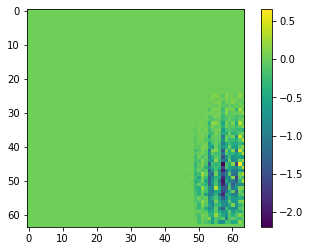

In [ ]:
n = model(-0.9739*tn.ones((1,4)).to(device_name).to(tn.float64)).cpu()

plt.figure()
plt.imshow(n[0,...].detach())
plt.colorbar()




In [ ]:
sum([ tn.numel(t) for t in list(model.parameters())])
train_inputs.min()
params

tensor([[-0.9739, -0.9739, -0.9739, -0.9739],
        [-0.9739, -0.9739, -0.9739, -0.9739],
        [-0.9739, -0.9739, -0.9739, -0.9739],
        ...,
        [-0.9739, -0.9739, -0.9739, -0.9739],
        [-0.9739, -0.9739, -0.9739, -0.9739],
        [-0.9739, -0.9739, -0.9739, -0.9739]], device='cuda:1')